In [1]:
import phoebe
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import emcee
import corner
from timeit import default_timer as timer
import pickle
import sys
%matplotlib inline

In this excercise you'll get to apply emcee to fit a synthetic binary light curve generated with Phoebe.

Let's first initialize the Bundle and set all the relevant parameters to generate the synthetic light curve.

In [2]:
b = phoebe.default_binary()

In [3]:
b['period@orbit'] = 0.5
b['sma@orbit'] = 3.5
b['incl@orbit'] = 83.5
b['requiv@primary'] = 1.2
b['requiv@secondary'] = 0.8
b['teff@primary'] = 6500.
b['teff@secondary'] = 5500.
true_values=(83.5,1.2,0.8,5500)

In [4]:
b.add_dataset('lc', times=np.linspace(0, 0.5, 51))

<ParameterSet: 19 parameters | contexts: compute, constraint, dataset>

In [5]:
b.run_compute()

<ParameterSet: 2 parameters | qualifiers: times, fluxes>

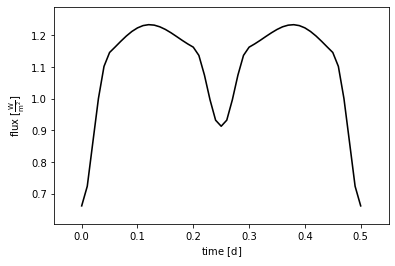

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 432x288 with 1 Axes>)

In [6]:
b.plot(show=True)

In [7]:
np.savetxt('data.lc', 
           np.vstack((b['value@times@lc01@model'], b['value@fluxes@lc01@model']+np.random.normal(0, 0.01, 51))).T)

Now our synthetic light curve (with some added scatter) has been saved to a file 'data.lc' and can be used as our "observed" light curve to fit.

### Exercise

1. Initialize a new Bundle and load the 'data.lc' file into an LC dataset. 
2. Set the values of the period, sma and primary teff as given above:
   - period = 0.5 d
   - sma = 3.5 solRad
   - teff1 = 6500 K
3. Sample the values of the inclination, equivalent radii and secondary teff following the guidelines provided in the fitting tutorial. 

For the purposes of this exercise, let's assume that you've used an external optimizer and already know that the values of the modeled parameters are: 
- incl ~ 83-84 deg
- r1 ~ 1.15-1.25
- r2 ~ 0.75 - 0.85
- teff2 ~ 5450-5550

*For better results, confine the initial distributions to the values given above. Time permitting, redo with different (narrower/broader) initial distributions and compare the results.*

*Try to limit the number of walkers to <50 and number of iterations to <20 to avoid long compute times (32 walkers + 10 iterations take about 10 min to compute on a single processor).*

In [8]:
(time_arr,flux_arr) = np.loadtxt('data.lc',unpack=True)
sigma_arr = np.zeros(len(time_arr))+0.015

## Set intial parameters

In [44]:
nwalkers = 10
niter = 5
#Order(incl,r1,r2,teff2)
init_dist = [(83,84),(1.15,1.25),(0.75,0.85),(5450,5550)]

## Set Priors
Will use uniform priors for now.

In [45]:
#Order(incl,r1,r2,teff2)
priors = [(0,90),(1.0,2.0),(0.5,1.0),(5400,6000)]

In [46]:
mod = phoebe.default_binary()

## Set star known parameters

In [47]:
mod.set_value(qualifier='period',context='component', component='binary',value=0.5)
mod.set_value(qualifier='sma',context='component', component='binary',value=3.5)
mod.set_value(qualifier='teff',component='primary',value=6500)

In [48]:
mod.add_dataset('lc', times = time_arr, fluxes=flux_arr, sigmas=sigma_arr,compute_phases=np.linspace(0,1.,51)
                , passband='Kepler:mean',dataset='lc01',overwrite=True)

<ParameterSet: 19 parameters | contexts: compute, constraint, dataset>

## Make the computations very crappy for this example

In [49]:
mod.get_parameter(context='compute', qualifier='irrad_method').set_value("none")
mod.get_parameter(context='compute', component='primary', qualifier='ntriangles').set_value(300)
mod.get_parameter(context='compute', component='secondary', qualifier='ntriangles').set_value(300)

In [50]:
mod.set_value('pblum_mode',value='dataset-scaled') #So that the model is automatically scaled to the data 
#(You don't always want this)

## Set up useful functions

In [51]:
def rpars(init_dist):
    '''
    Pick a starting point from a uniform distributions
    '''
    return [np.random.rand() * (i[1]-i[0]) + i[0] for i in init_dist]

In [52]:
def lnprior(priors, values):
    '''
    Using a uniform prior, so values outside the prior range are set to -infinity
    '''    
    lp = 0.
    for value, prior in zip(values, priors):
        if value >= prior[0] and value <= prior[1]:
            lp+=0
        else:
            lp+=-np.inf 
    return lp

In [53]:
def lnprob(model_params,sigma_arr):
    '''
    Calculate the probability for each dataset. 
    '''
    #Model_params order(incl,r1,r2,teff2)
    mod.set_value(qualifier='incl',context='component', component='binary',value=model_params[0])
    mod.set_value(qualifier='requiv',context='component', component='primary',value=model_params[1])
    mod.set_value(qualifier='requiv',context='component', component='secondary',value=model_params[2])
    mod.set_value(qualifier='teff',component='secondary',value=model_params[3])
    
    #Get the log prior probabilities
    lnp = lnprior(priors,model_params)
    if not np.isfinite(lnp):
            return -np.inf
    
    try: 
        mod.run_compute()

        # use chi^2 to compare the model to the data:
        chi2 = 0.
        #compute_residuals only works on LC and RV dataset types
        #This will make the final chi2 a sum across all of these.
        for dataset in mod.get_model().datasets:
            chi2+=np.sum(mod.compute_residuals(dataset=dataset, as_quantity=False)**2/sigma_arr**2)
        # calculate lnprob
        lnprob = -0.5*chi2 + lnp
        return lnprob
    except:
        return -np.inf

In [54]:
def run(init_dist, nwalkers, niter, sigma_arr,true_values):
    # Specify the number of dimensions for mcmc
    ndim = len(init_dist)

    # Generate initial guesses for all parameters for all chains
    p0 = np.array([rpars(init_dist) for i in range(nwalkers)])

    # Generate the emcee sampler. Here the inputs provided include the lnprob function. With this setup, the value z
    # in the lnprob function, is the output from the sampler.
    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(sigma_arr,))
    
    #pos is the position of the walkers in parameter space
    #prob is the probability of the given "pos" positions
    #state is the state of the random number generator
    start = timer()
    pos, prob, state = sampler.run_mcmc(p0, niter)
    print("Total time: {:.2f}".format((timer() - start)/60.0 ))
    
    return pos,sampler

In [55]:
def hist_fig(sampler,ndim):
    labels = ["$incl$", "$r_1$", "$r_2$","$teff_2$"]
    for i in range(ndim):
        plt.figure()
        y = sampler.flatchain[:,i]
        n, bins, patches = plt.hist(y, 200, density=1, color="b", alpha=0.45)#, histtype="step")
        plt.title("Dimension {}".format(labels[i]))
        
        mu = np.average(y)
        sigma = np.std(y)
        
        print("mu = ", mu)
        print("sigma = ",sigma)

        bf = norm.pdf(bins, mu, sigma)
        plt.plot(bins, bf, 'k--', linewidth=2.0)

    plt.show()  

In [56]:
def walker_fig(sampler,ndim,true_val):
    fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    samples = sampler.chain
    print(samples.shape)
    labels = ["$incl$", "$r_1$", "$r_2$","$teff_2$"]
    for i in range(ndim):
        ax = axes[i]
        for j in range(len(samples)):
            if(i == 2):
                ax.plot(samples[j, :, i], "k", alpha=0.1)
            else:
                ax.plot(samples[j, :, i], "k", alpha=0.1)
        ax.set_xlim(0, len(samples[1]))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
        ax.axhline(true_val[i])

    axes[-1].set_xlabel("step number")
    plt.show()

In [64]:
def fit_plot(mod,sampler,nwalkers,time_arr,true_value,ndim):
    
    #Plot actual data
    times = mod.get_value(dataset='lc01',qualifier='times',context='dataset')
    fluxes = mod.get_value(dataset='lc01',qualifier='fluxes',context='dataset')
    plt.plot(times,fluxes,'.k')
    
    samples = sampler.chain[:, :, :].reshape((-1, ndim))
    
    #Limit number of samples to 100
    size=len(samples) #For small numbers of samples    
    if size > 100:
        size = 100
    for model_params in samples[np.random.randint(len(samples), size=size)]:
        #Model_params order(incl,r1,r2,teff2)
        mod.set_value(qualifier='incl',context='component', component='binary',value=model_params[0])
        mod.set_value(qualifier='requiv',context='component', component='primary',value=model_params[1])
        mod.set_value(qualifier='requiv',context='component', component='secondary',value=model_params[2])
        mod.set_value(qualifier='teff',component='secondary',value=model_params[3])
        
        mod.run_compute(overwrite=True)
        
        model = mod.get_parameter(context='model',qualifier='fluxes').interp_value(times=times)

        plt.plot(times,model,c='k',alpha=0.01)
        
    
    plt.xlabel("Times")
    plt.ylabel("Flux")
    plt.show()

## Runtimes

| Walkers | interations | Time(min |
|---|---|---|
| 10 | 2 | 1.38 |
| 10 | 5 | 2.37 |
| 10 | 10 | 3.64 |
| 10 | 20 | 7.02 |
| 10 | 50 | 18.17 |
|10 | 500 | 166.14 |
|20 | 2 | 2.10 | 
|20 | 5 |4.54 |
|20 | 10 | 8.37 |
|20 | 20 | 18.15|
|20 | 50 | 42.25|


In [58]:
pos,sampler = run(init_dist, nwalkers, niter, sigma_arr,true_values)

Total time: 2.32


In [59]:
pickle.dump(sampler,open('emcee_fit_10w5i.p','wb'))

In [69]:
sampler = pickle.load(open('emcee_fit_10w500i.p','rb'))

mu =  83.78803045022448
sigma =  1.5238508704764053
mu =  1.1832827332807745
sigma =  0.016859034979919217
mu =  0.818932779441061
sigma =  0.04682067368565005
mu =  5456.859101320413
sigma =  36.374611424180856


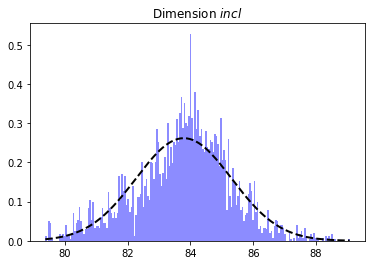

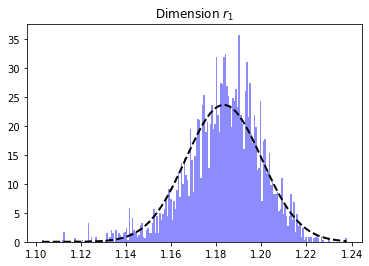

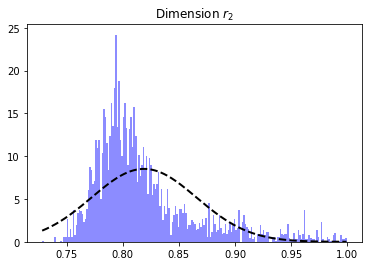

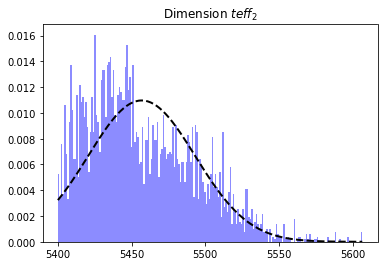

In [70]:
ndim = len(init_dist)
hist_fig(sampler,ndim)

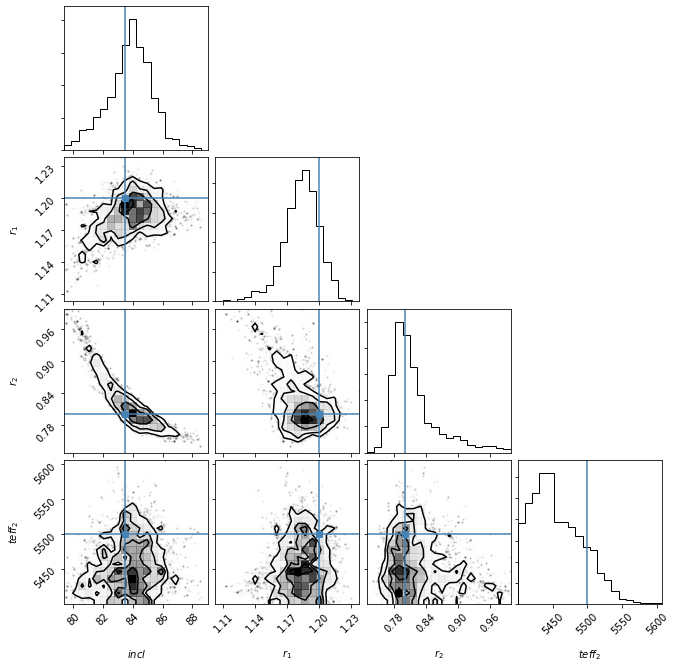

In [71]:
samples = sampler.chain[:, :, :].reshape((-1, ndim))
corner.corner(samples, labels=["$incl$", "$r_1$", "$r_2$","$teff_2$"],truths=true_values)
plt.show()

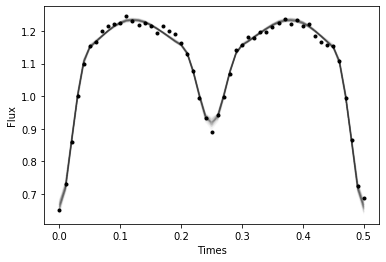

In [72]:
fit_plot(mod,samples,nwalkers,time_arr,true_values)

(10, 500, 4)


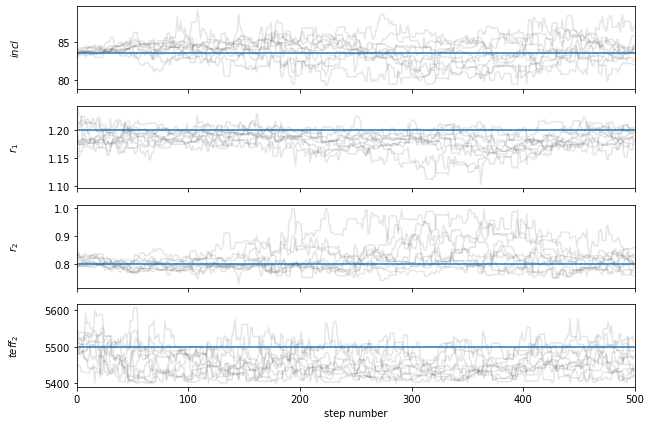

In [73]:
walker_fig(sampler,ndim,true_values)